---
<div style="background-color:white; text-align:center; padding:20px;">
    <h2 style="color:black; font-family: Verdana, sans-serif;"><strong>Berenklauw classificatie</strong></h2>
    <p style="font-size: 14px; color: black; font-family: Verdana, sans-serif;"> 
        <table style="margin: auto; border-collapse: collapse;">
            <tr>
                <th style="border: 0;">Teamleden</th>
                <th style="border: 0;">GitHub Username</th>
            </tr>
            <tr>
                <td style="border: 0;">Vince Ammerlaan</td>
                <td style="border: 0;">Vince16270</td>
            </tr>
            <tr>
                <td style="border: 0;">Tommi Lander</td>
                <td style="border: 0;">tommi7</td>
            </tr>
            <tr>
                <td style="border: 0;">Nima Ghafar</td>
                <td style="border: 0;">NimaGhafar</td>
            </tr>
        </table>
    </p>
</div>

<div style="display: flex; justify-content: center; align-items: center; margin-top:20px;">
    <img src="https://www.hpg-hoveniers.nl/wp-content/uploads/2015/06/berenklauw-bestrijden-1024x768.jpg" alt="genres" style="max-width: 100%; max-height: 100%;">
</div>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Table of contents </strong></h2>
</div>
<ul style="padding: 0; list-style: none;">
    <li style="text-align: center;"><a href="#1.0">Chapter 1: Packages, data en zelfgedefineerde functie's inladen</a></li>
    <li style="text-align: center;"><a href="#2.0">Chapter 2: Exploratory Data Analysis</a></li>
    <li style="text-align: center;"><a href="#3.0">Chapter 3: Model</a></li>
    <li style="text-align: center;"><a href="#5.0">Chapter 4: Model evaluatie</a></li>
    <li style="text-align: center;"><a href="#6.0">Chapter 5: Bevindingen</a></li>
    <li style="text-align: center;"><a href="#7.0">Chapter 6: Conclusie en aanbevelingen</a></li>
    <li style="text-align: center;"><a href="#8.0">Chapter 7: Bronnenlijst</a></li>
</ul>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 1: Packages, data en zelfgedefineerde functie's inladen </strong></h2>
</div>

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
import cv2
import PIL
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
import torch
from torchvision import models, transforms
import numpy as np


c:\Users\nimaa\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Zelfgedefineerde functie's inladen

In [4]:
def load_images_and_masks(image_folder, mask_folder):
    """
    Laad afbeeldingen en hun bijbehorende maskers uit de opgegeven mappen, wijzig hun grootte naar 224x224 en zet ze om naar numpy arrays.

    Parameters:
    image_folder (str): Pad naar de map met de afbeeldingen.
    mask_folder (str): Pad naar de map met de maskers.

    Geeft terug:
    tuple: Een tuple met twee numpy arrays, een voor de afbeeldingen en een voor de maskers.

    """
    image_filenames = sorted(os.listdir(image_folder))
    images = []
    masks = []
    for img_file in image_filenames:
        img_path = os.path.join(image_folder, img_file)
        mask_file = img_file  
        mask_path = os.path.join(mask_folder, mask_file)
        img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
        img_array = keras.preprocessing.image.img_to_array(img)
        mask = keras.preprocessing.image.load_img(mask_path, color_mode="grayscale", target_size=(224, 224))
        mask_array = keras.preprocessing.image.img_to_array(mask)
        images.append(img_array)
        masks.append(mask_array)
    return np.array(images), np.array(masks)

In [5]:
def display_images(display_list):
    """
    Toon een lijst van afbeeldingen in een enkele figuur.

    Parameters:
    display_list (list): Een lijst van afbeeldingen om te tonen. De afbeeldingen moeten numpy arrays zijn.

    De functie toont een figuur met de 'Input Image', 'True Mask' en 'Predicted Mask' naast elkaar.
    """
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')

    plt.show()

In [6]:
def create_mask(pred_mask):
    """
    Maak een masker van de voorspelde masker door het kiezen van de index met de hoogste waarde op de laatste as.

    Parameters:
    pred_mask (tensor): Een tensor die de voorspelde masker bevat.

    Geeft terug:
    tensor: Een tensor die het gecreëerde masker bevat.
    """
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Toon de voorspellingen van het model. Als een dataset is gegeven, toont het de voorspellingen op de eerste 'num' afbeeldingen in de dataset. 
    Anders toont het de voorspelling op de 'sample_image'.

    Parameters:
    dataset (tf.data.Dataset, optional): De dataset waarop de voorspellingen worden getoond. Standaard is None.
    num (int, optional): Het aantal afbeeldingen om te tonen uit de dataset. Standaard is 1.

    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display_images([image[0], mask[0], create_mask(pred_mask)])
    else:
        display_images([sample_image, sample_mask,
                        create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [7]:
def plot_loss_and_accuracy(history):
    """
    Plot de training en validatie verlies en accuracy over de epochs.

    Parameters:
    history (History): Het model waarin is in opgeslagen.

    De functie maakt een figuur met twee subplots: de eerste toont de training en validatie loss waarden, en de tweede toont de training en validatie accuracy.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training en Validatie Verliezen')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Verlies')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Nauwkeurigheid')
    ax2.plot(history.history['val_accuracy'], label='Validatie Nauwkeurigheid')
    ax2.set_title('Training en Validatie Nauwkeurigheden')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Nauwkeurigheid')
    ax2.legend()

    plt.show()

In [8]:
def apply_mask_to_image(image, mask):
    """
    Pas een masker toe op een afbeelding. Als het masker volledig nul is, wordt de originele afbeelding geretourneerd. Anders wordt het masker toegepast op de afbeelding.

    Parameters:
    image (tensor): Een tensor die de afbeelding bevat.
    mask (tensor): Een tensor die het masker bevat.

    Geeft terug:
    tensor: Een tensor die de gesegmenteerde afbeelding bevat.
    """
    if tf.reduce_all(mask == 0):
        return image
    else:
        segmented_image = image * tf.cast(mask, image.dtype)
        return segmented_image
    
def display(display_list):
    """
    Toon een lijst van afbeeldingen in een enkele figuur.

    Parameters:
    display_list (list): Een lijst van afbeeldingen om te tonen. De afbeeldingen moeten numpy arrays zijn.

    De functie toont een figuur met de 'Input Image', 'True Mask', 'Predicted Mask' en 'Segmented Image' naast elkaar.
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask', 'Segmented Image']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions_2(dataset=None, num=1):
    """
    Toon de voorspellingen van het model. Als een dataset is gegeven, toont het de voorspellingen op de eerste 'num' afbeeldingen in de dataset. 
    Anders toont het de voorspelling op de 'sample_image'.

    Parameters:
    dataset (tf.data.Dataset, optional): De dataset waarop de voorspellingen worden getoond. Standaard is None.
    num (int, optional): Het aantal afbeeldingen om te tonen uit de dataset. Standaard is 1.

    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask), 
                     apply_mask_to_image(image[0], create_mask(pred_mask))])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...])),
                 apply_mask_to_image(sample_image, create_mask(model.predict(sample_image[tf.newaxis, ...])))])

**Hier splitsen we de data in 4 verschillende plaatjes, zodat we meer data beschikbaar hebben**

In [9]:
#def splits_en_opslaan_afbeeldingen(map_pad, nieuwe_map_pad):
    #if not os.path.exists(nieuwe_map_pad):
        #os.makedirs(nieuwe_map_pad)

    #bestandsnamen = os.listdir(map_pad)

    #for bestandsnaam in bestandsnamen:
        #afbeelding_pad = os.path.join(map_pad, bestandsnaam)
        #if os.path.isfile(afbeelding_pad):
            #afbeelding = Image.open(afbeelding_pad)
            #breedte, hoogte = afbeelding.size
            #helft_breedte = breedte // 2
            #helft_hoogte = hoogte // 2

            #kwadrant_1 = afbeelding.crop((0, 0, helft_breedte, helft_hoogte))
            #kwadrant_2 = afbeelding.crop((helft_breedte, 0, breedte, helft_hoogte))
            #kwadrant_3 = afbeelding.crop((0, helft_hoogte, helft_breedte, hoogte))
            #kwadrant_4 = afbeelding.crop((helft_breedte, helft_hoogte, breedte, hoogte))

            # Opslaan van de de delen van de afbeelding
            #kwadrant_1.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel1.jpg'))
            #kwadrant_2.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel2.jpg'))
            #kwadrant_3.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel3.jpg'))
            #kwadrant_4.save(os.path.join(nieuwe_map_pad, bestandsnaam.split('.')[0] + '_deel4.jpg'))

#image_map_pad = 'images'
#nieuwe_image_map_pad = 'image_kwadranten'
#splits_en_opslaan_afbeeldingen(image_map_pad, nieuwe_image_map_pad)

#mask_map_pad = 'masks'
#nieuwe_mask_map_pad = 'mask_kwadranten'
#splits_en_opslaan_afbeeldingen(mask_map_pad, nieuwe_mask_map_pad)


#def toon_willekeurige_afbeeldingen_per_set(train_afbeeldingen, test_afbeeldingen):
    #train_afbeelding = train_afbeeldingen[np.random.randint(len(train_afbeeldingen))]
    #test_afbeelding = test_afbeeldingen[np.random.randint(len(test_afbeeldingen))]

    #fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    #axs[0].imshow(train_afbeelding)
    #axs[0].set_title("Image Set")
    #axs[0].axis('off')
    #axs[1].imshow(test_afbeelding)
    #axs[1].set_title("Mask Set")
    #axs[1].axis('off')
    #plt.show()

#image_map_pad = 'image_kwadranten'y
#image_afbeeldingen = laad_afbeeldingen(image_map_pad)

#mask_map_pad = 'mask_kwadranten'
#mask_afbeeldingen = laad_afbeeldingen(mask_map_pad)

#display(image_afbeeldingen.shape, mask_afbeeldingen.shape)
#toon_willekeurige_afbeeldingen_per_set(image_afbeeldingen, mask_afbeeldingen)

### Afbeeldingen en masks data inladen

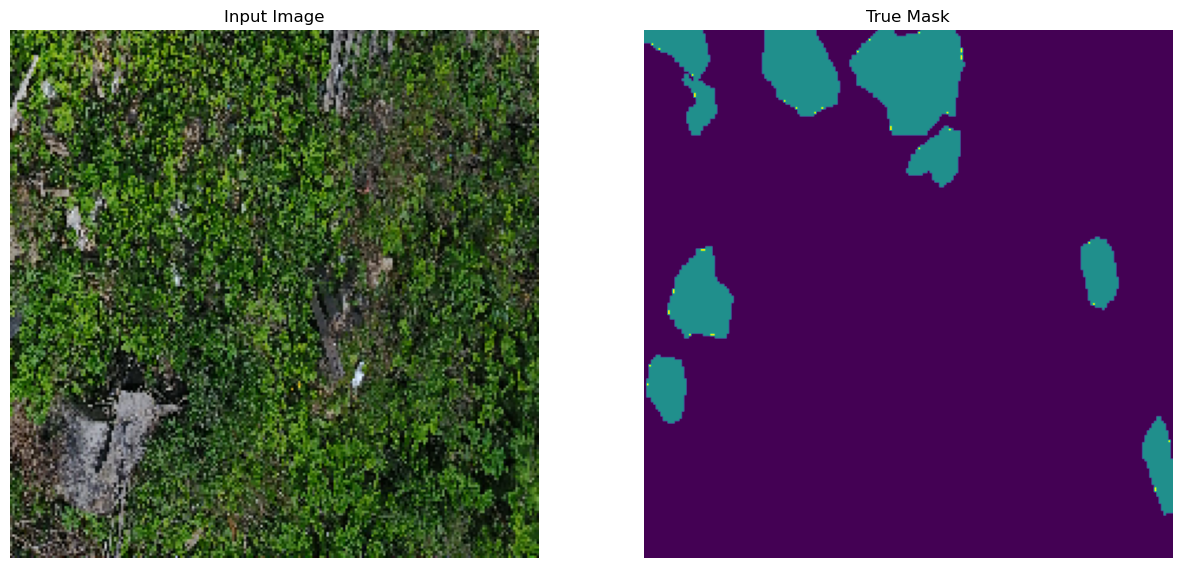

In [ ]:
image_folder = 'image_kwadranten'
mask_folder = 'mask_kwadranten'

images, masks = load_images_and_masks(image_folder, mask_folder)
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=42)

sample_image, sample_mask = train_images[3], train_masks[3]
display_list = [sample_image, sample_mask]  
display_images(display_list)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 2: Exploratory Data Analysis </strong></h2>
</div>

In [ ]:
num_images_without_masks = sum(np.all(mask == 0) for mask in train_masks)
percentage_without_masks = num_images_without_masks / len(train_masks) * 100

print(f"Aantal afbeeldingen in de dataset: {len(train_masks)}")
print(f"Aantal afbeeldingen met maskers: {len(train_masks) - num_images_without_masks}")
print(f"Aantal afbeeldingen zonder maskers: {num_images_without_masks}")
print(f"Percentage afbeeldingen met maskers: {100 - round(percentage_without_masks, 2)}%")
print(f"Percentage afbeeldingen zonder maskers: {round(percentage_without_masks, 2)}%")

Aantal afbeeldingen in de dataset: 841
Aantal afbeeldingen met maskers: 695
Aantal afbeeldingen zonder maskers: 146
Percentage afbeeldingen met maskers: 82.64%
Percentage afbeeldingen zonder maskers: 17.36%


In [ ]:
print(f"Afbeelding lengte en breedte: {images[0].shape}")

Afbeelding lengte en breedte: (224, 224, 3)


In [ ]:
data = []

for i in range(len(images)):
    height, width, channels = images[i].shape
    size = height * width
    has_mask = np.any(masks[i])
    mask_coverage = np.sum(masks[i]) / size
    aspect_ratio = width / height
    avg_color = np.mean(images[i], axis=(0, 1)) / 255  
    avg_color_hex = mcolors.rgb2hex(avg_color)  # Converteer naar HTML-kleur
    # Voeg de gegevens toe aan de lijst
    data.append([i, width, height, size, has_mask, mask_coverage, avg_color, avg_color_hex])

images_info = pd.DataFrame(data, columns=['image_id', 'Breedte', 'Hoogte', 'Grootte',
                                           'Heeft een mask', 'Mask bedekking','Verdeling kleuren', 'Gemiddelde kleur HTML'])

images_info.head(10)

NameError: name 'mcolors' is not defined

1. `image_id`: Dit is een unieke identificatie voor elke afbeelding in de dataset. In dit geval is het de index van de afbeelding in de lijst `images`. Bijvoorbeeld, `0` betekent dat dit de eerste afbeelding in de lijst is. Het is belangrijk om elke afbeelding te kunnen identificeren, vooral als je later naar specifieke afbeeldingen wilt verwijzen.

2. `Breedte`: Dit is de breedte van de afbeelding in pixels. In dit geval is de breedte `224` pixels. Het kennen van de afmetingen van de afbeelding kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

3. `Hoogte`: Dit is de hoogte van de afbeelding in pixels. In dit geval is de hoogte `224` pixels. Net als de breedte kan de hoogte nuttig zijn bij het analyseren van de afbeelding.

4. `Grootte`: Dit is het totale aantal pixels in de afbeelding, berekend als breedte x hoogte. In dit geval is de grootte `50176` pixels. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de grootte van de afbeelding de maskerdekking beïnvloedt.

5. `Heeft een mask`: Dit geeft aan of de afbeelding een bijbehorend masker heeft. In dit geval heeft de afbeelding geen masker (`False`). Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de aanwezigheid van een masker de andere kenmerken van de afbeelding beïnvloedt.

6. `Mask bedekking`: Dit is het percentage van de afbeelding dat wordt bedekt door het masker, berekend als het aantal maskerpixels gedeeld door het totale aantal pixels. In dit geval is de maskerdekking `0.000000`, wat betekent dat er geen masker is. Dit kan nuttig zijn bij het analyseren van de afbeelding, bijvoorbeeld om te begrijpen hoe de maskerdekking de andere kenmerken van de afbeelding beïnvloedt.

7. `Verdeling kleuren`: Dit is de gemiddelde kleur van de afbeelding, berekend als de gemiddelde RGB-waarde van alle pixels en genormaliseerd tussen 0 en 1. In dit geval is de gemiddelde kleur `[0.3177765, 0.31320137, 0.20988709]`, wat een donkerbruine kleur is. Het kennen van de gemiddelde kleur kan nuttig zijn bij het analyseren van de afbeelding, zodat je weet hoe verschillend de kleuren zijn.

8. `Gemiddelde kleur HTML`: Dit is de gemiddelde kleur van de afbeelding, omgezet naar een HTML-kleur (hexadecimale kleurcode). In dit geval is de gemiddelde kleur `#515036`, wat overeenkomt met de RGB-kleur in de 'Verdeling kleuren' kolom. Het kennen van de HTML-kleur kan nuttig zijn voor visualisatiedoeleinden, bijvoorbeeld om een overzicht van de gemiddelde kleuren van de afbeeldingen te maken.

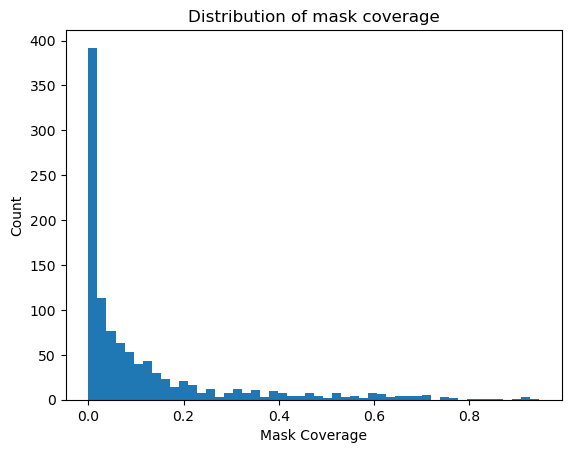

In [ ]:
plt.hist(images_info['Mask bedekking'], bins=50)
plt.xlabel('Mask Coverage')
plt.ylabel('Count')
plt.title('Distribution of mask coverage')
plt.show()

We zien dat er veel afbeeldingen zijn zonder of weinig maskers. Dit is dan moeilijk voor het model om te leren. 
Wel is dit nodig, omdat we kunnen zien dat het model ook werkt als er geen berenklauw te zien is. 
Zoals eerder is aangegeven is 17% van de afbeeldingen zonder masker. Dit is een prima percentage om mee te werken, omdat het model ook moet leren om afbeeldingen zonder masker te herkennen meestal afbeeldingen zijn zonder berenklauwen.

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 3: Model </strong></h2>
</div>

In [ ]:
width, height = 224, 224

base_model = ResNet50(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'conv1_relu',
    'conv2_block3_out',
    'conv3_block4_out',
    'conv4_block6_out',
    'conv5_block3_out',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

ResNet_50 = tf.keras.models.Model(base_model.input,
                            base_model_outputs)

2024-04-15 10:56:20.638404: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-04-15 10:56:20.638437: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-04-15 10:56:20.638453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-04-15 10:56:20.638840: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-15 10:56:20.638859: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
def fcn8_decoder(convs, n_classes):
    n = 4096

    c6 = tf.keras.layers.Conv2D(n, (7, 7), activation='relu', padding='same', name="conv6")(convs[-1])
    c7 = tf.keras.layers.Conv2D(n, (1, 1), activation='relu', padding='same', name="conv7")(c6)

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(c7)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(convs[3])
    o = tf.keras.layers.Add()([o, o2])

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(4, 4), strides=(2, 2), use_bias=False)(o)
    o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

    o2 = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='relu', padding='same')(convs[2])
    o = tf.keras.layers.Add()([o, o2])

    o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(8, 8), strides=(8, 8), use_bias=False)(o)

    o = tf.keras.layers.Activation('softmax')(o)
    return o

In [ ]:
def segmentation_model():
	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = ResNet_50(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)
	return model

opt = keras.optimizers.legacy.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
			metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 112, 112, 64),       2358771   ['input_2[0][0]']             
                              (None, 56, 56, 256),        2                                       
                              (None, 28, 28, 512),                                                
                              (None, 14, 14, 1024),                                               
                              (None, 7, 7, 2048)]                                                 
                                                                                            

In [ ]:
BATCH_SIZE = 32
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks)).batch(BATCH_SIZE)

model_history = model.fit(train_ds, epochs=15, validation_data=test_ds)

Epoch 1/15


2024-04-15 10:56:25.404112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - ETA: 0s - loss: 1.0427 - accuracy: 0.4635

2024-04-15 10:57:07.952097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 53s 2s/step - loss: 1.0427 - accuracy: 0.4635 - val_loss: 0.8847 - val_accuracy: 0.5837
Epoch 2/15
27/27 [==============================] - 48s 2s/step - loss: 0.6915 - accuracy: 0.7010 - val_loss: 0.4889 - val_accuracy: 0.8302
Epoch 3/15
27/27 [==============================] - 48s 2s/step - loss: 0.3745 - accuracy: 0.8648 - val_loss: 0.3195 - val_accuracy: 0.8871
Epoch 4/15
27/27 [==============================] - 55s 2s/step - loss: 0.2752 - accuracy: 0.8936 - val_loss: 0.2869 - val_accuracy: 0.8923
Epoch 5/15
27/27 [==============================] - 47s 2s/step - loss: 0.2378 - accuracy: 0.9010 - val_loss: 0.2862 - val_accuracy: 0.8967
Epoch 6/15
27/27 [==============================] - 48s 2s/step - loss: 0.2180 - accuracy: 0.9094 - val_loss: 0.2928 - val_accuracy: 0.9009
Epoch 7/15
27/27 [==============================] - 48s 2s/step - loss: 0.2058 - accuracy: 0.9195 - val_loss: 0.3540 - val_accuracy: 0.9037
Epoch 8/15
27/27 [=============

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 4: Model evaluatie </strong></h2>
</div>

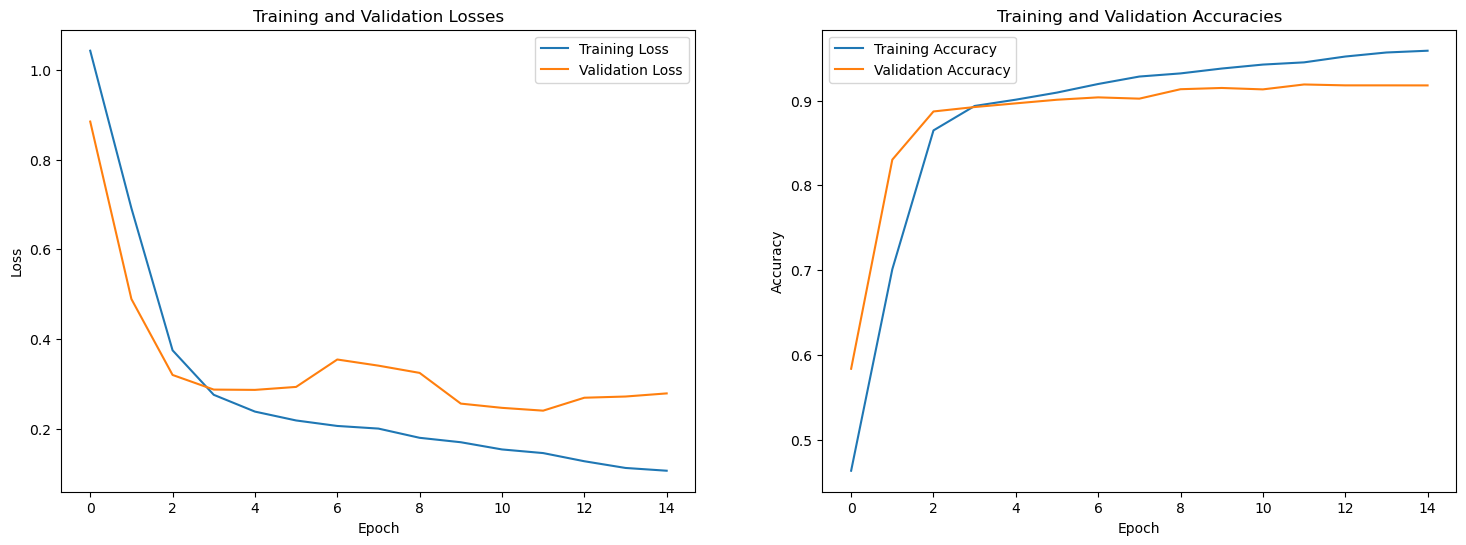

In [ ]:
plot_loss_and_accuracy(model_history)

2024-04-15 11:09:35.123613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 926ms/step


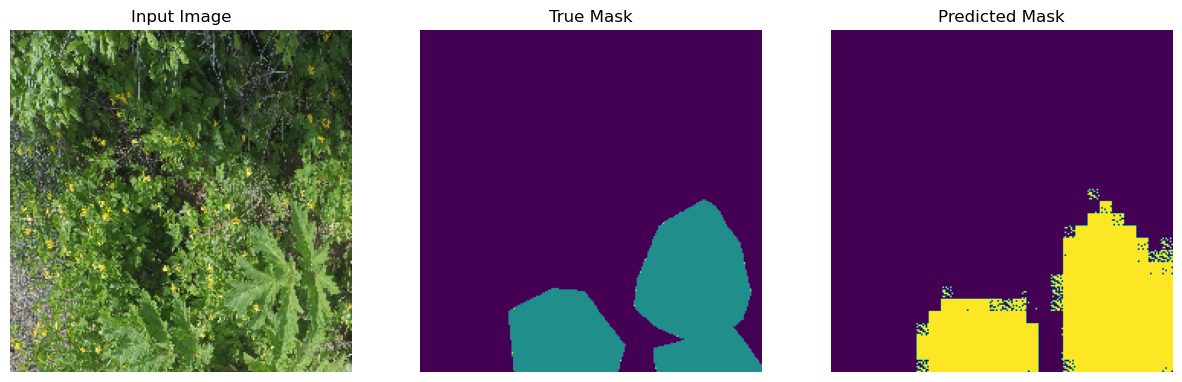

In [ ]:
show_predictions()

1/1 [==============================] - 0s 16ms/step


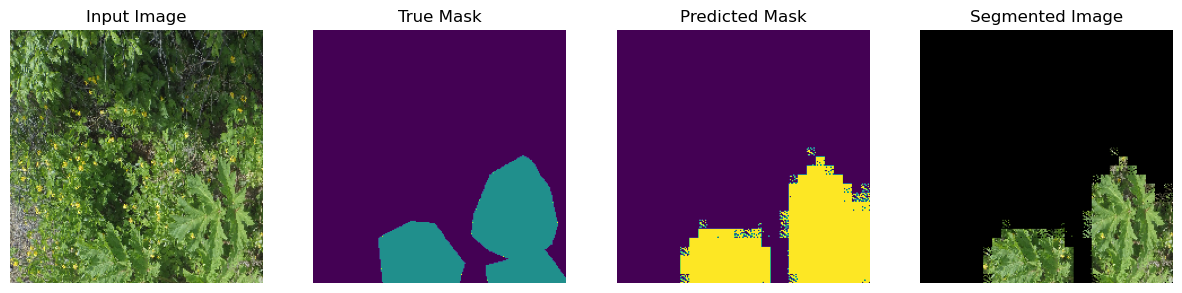

In [ ]:
show_predictions_2()

1/1 [==============================] - 0s 260ms/step


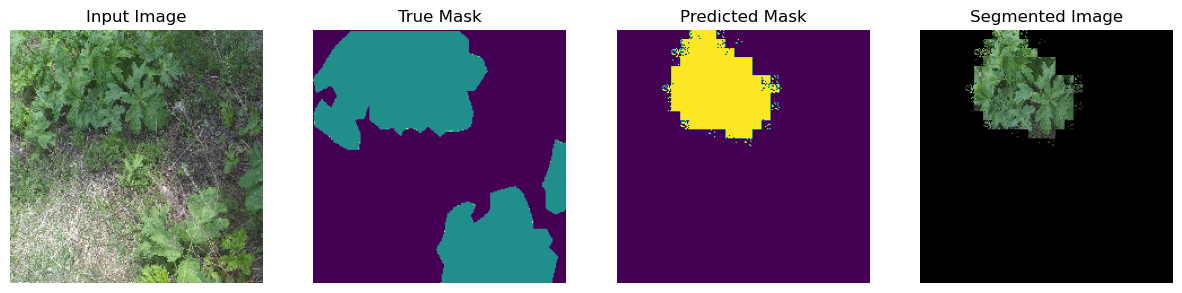

1/1 [==============================] - 0s 36ms/step


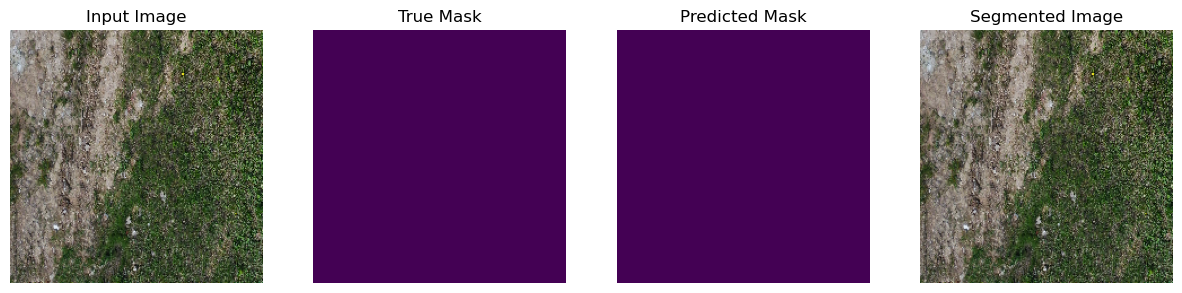

1/1 [==============================] - 0s 36ms/step


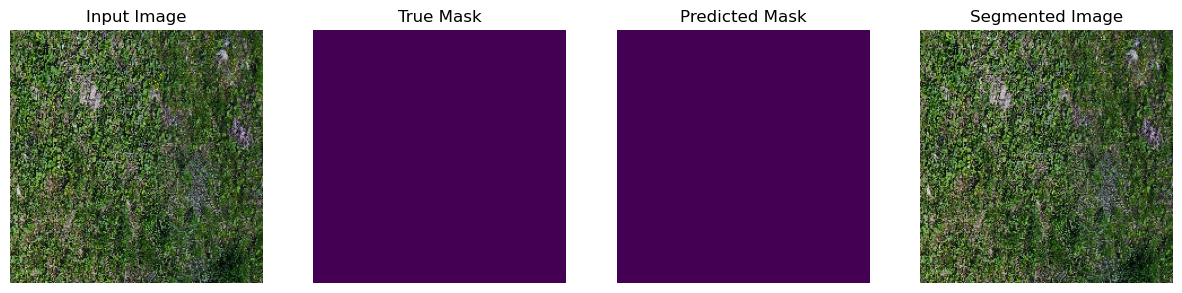

1/1 [==============================] - 0s 23ms/step


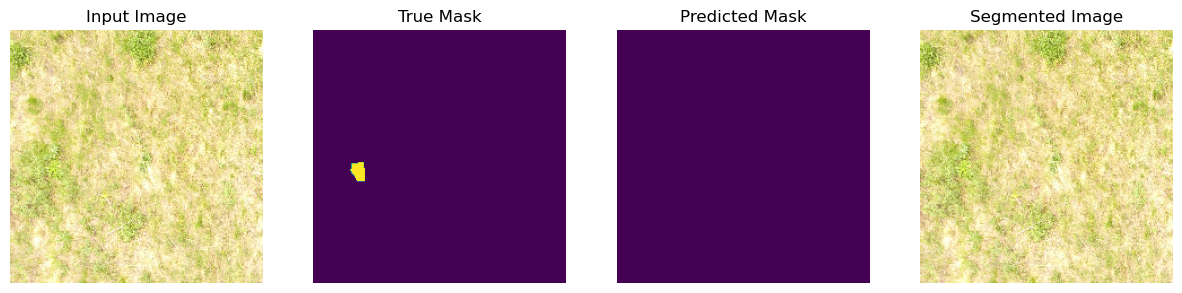

1/1 [==============================] - 0s 22ms/step


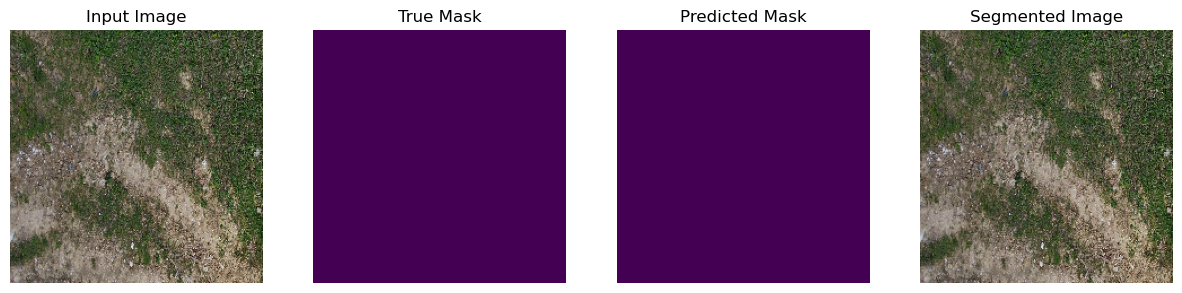

1/1 [==============================] - 0s 25ms/step


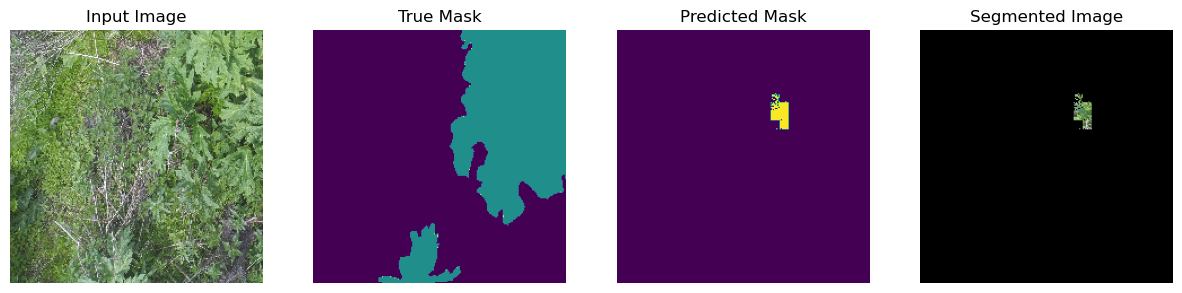

1/1 [==============================] - 0s 407ms/step


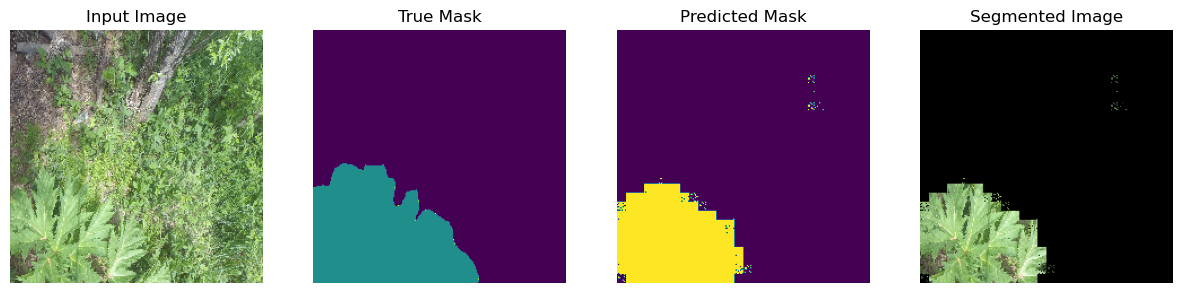

In [ ]:
show_predictions(test_ds, num=10030)

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 5: Bevindingen </strong></h2>
</div>

In [ ]:
def load_jpeg_images(image_folder):
    image_filenames = sorted(os.listdir(image_folder))
    images = []
    for img_file in image_filenames:
        if img_file.endswith(".jpeg"):
            img_path = os.path.join(image_folder, img_file)
            img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = keras.preprocessing.image.img_to_array(img)
            images.append(img_array)
    return np.array(images)

test_images = load_jpeg_images('eigen data')

In [ ]:
def show_predictions_on_testset(test_dataset, num=1):
    for image, mask in test_dataset.take(num):
        pred_mask = model.predict(image)
        display_images([image[0], mask[0], create_mask(pred_mask)])

show_predictions_on_testset(test_images, num=3)

TypeError: 'numpy.float32' object is not iterable

In [ ]:
evaluation_results = model.evaluate(test_images)
print("Evaluation results:", evaluation_results)

2024-04-15 11:33:18.392545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 11ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Evaluation results: [0.0, 0.0]


In [ ]:
show_predictions(test_images, num=10030)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 6: Conclusie en aanbevlingen </strong></h2>
</div>

---
<div style="background-color:white; text-align:center; vertical-align:middle; padding:50px 0; margin-top:5px; margin-bottom:5px">
    <h2 id="eda-title" style="color:black; font-family: Verdana, sans-serif; font-size: 25px;"><strong> Chapter 7: Bronnenlijst </strong></h2>
</div>

### EDGE DETECTION TOMMI

Preprocessed Image


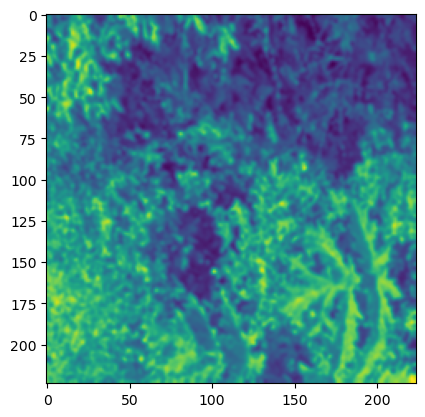

In [ ]:
def preprocess_images(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return blurred

preprocessed_train_images = [preprocess_images(image) for image in train_images]
print(f"Preprocessed Image", )
plt.imshow(preprocessed_train_images[0])



In [ ]:
def detect_edges(image):
    image_uint8 = np.uint8(image)
    edges = cv2.Canny(image_uint8, 50, 150)
    return edges

edge_detected_train_images = [detect_edges(image) for image in preprocessed_train_images]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


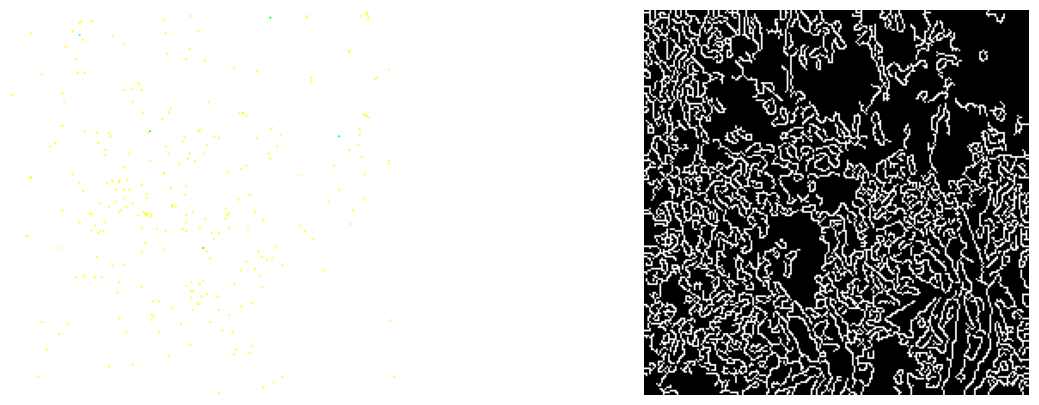

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


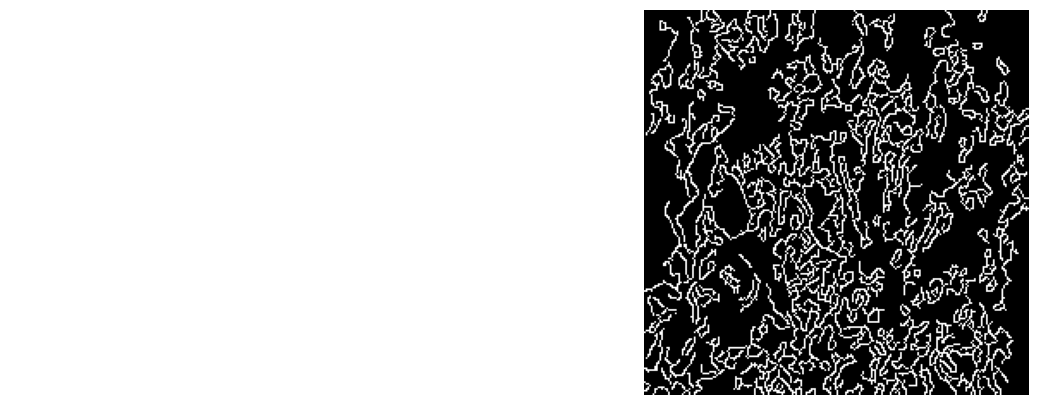

In [ ]:
def display_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for i, image in enumerate(images):
        axes[i].imshow(image, cmap='gray')
        axes[i].axis('off')
    plt.show()

for i in range(2):
    display_list = [train_images[i], edge_detected_train_images[i]]
    display_images(display_list)

In [ ]:
#het eerste plaatje laat zien waar de beurenklauw zich bevind, de 2e foto laat de randen zien die zijn gevonden door het Canny model 

### Berenklauw features

In [ ]:
def preprocess_image(image):
    if len(image.shape) == 2: 
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) 
    elif image.shape[2] == 1:  
        image = np.concatenate([image] * 3, axis=2) 
    image = Image.fromarray(image.astype('uint8'))
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

model = models.resnet50(pretrained=True)
model.eval()

def extract_features(image):
    input_batch = preprocess_image(image)
    with torch.no_grad():
        output = model(input_batch)
    features = output.squeeze().numpy()  
    return features

berenklauw_features = [extract_features(image) for image in train_images]

c:\Users\nimaa\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nimaa\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\nimaa/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.2MB/s]


In [ ]:
#De feautre extraction is al vooraf getrained en laat alleen features van de plaatjes zoals kleur en randen van de afbeelding, 
#dit is niet optimaal voor ons probleem omdat bijvoorbeeld echt de vorm van alleen de berenklauw belangrijk is en niet van heel de afbeelding dit moeten we verder onderzoeken.

### MODEL 

In [ ]:
num_epochs = 1000
patience = 30
input_size = 100
output_size = 1


model = Sequential([
    Dense(64, activation='relu', input_shape=(input_size,)),
    Dropout(0.3),  
    Dense(64, activation='relu'),
    Dropout(0.3),  
    Dense(32, activation='relu'),
    Dense(16, activation='relu'), 
    Dense(8, activation='relu'), 
    Dense(output_size)
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

history = model.fit(train_features, train_labels,
                    validation_data=(val_features, val_labels),
                    epochs=num_epochs,
                    callbacks=[stop_early])

val_loss, val_acc = model.evaluate(val_features, val_labels)

Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4484 - loss: 4.3531 - val_accuracy: 0.6000 - val_loss: 0.6663
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5086 - loss: 2.0729 - val_accuracy: 0.5500 - val_loss: 0.6911
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4781 - loss: 1.2326 - val_accuracy: 0.5000 - val_loss: 0.7179
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4859 - loss: 1.3202 - val_accuracy: 0.6500 - val_loss: 0.6956
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5016 - loss: 0.7627 - val_accuracy: 0.5500 - val_loss: 0.6892
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4695 - loss: 1.1848 - val_accuracy: 0.5500 - val_loss: 0.6965
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5367 - loss: 0.8006 - val_accuracy: 0.5500 - val_loss: 0.7027
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5055 - loss: 0.9587 - val_accuracy: 0.5000 - v

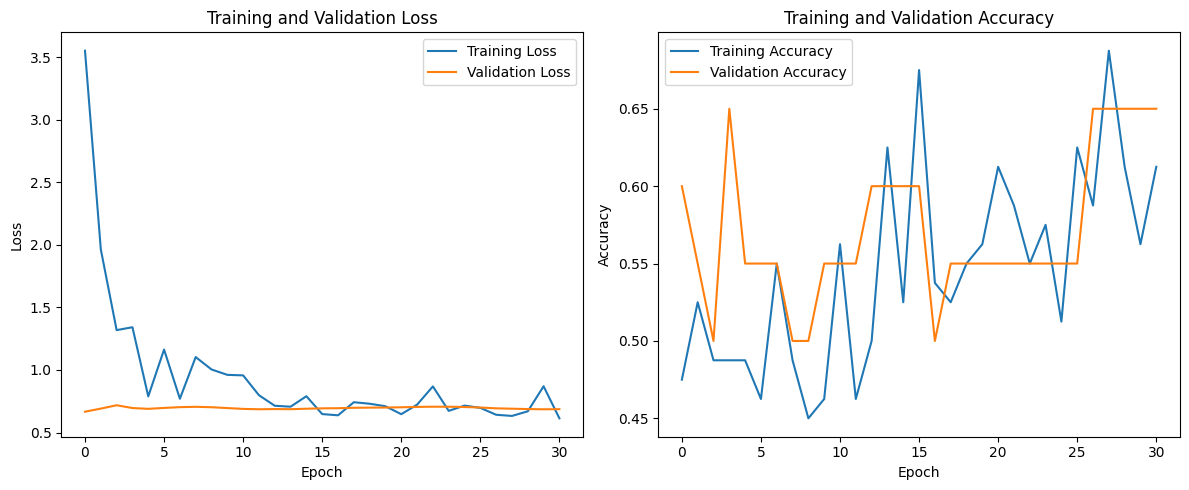

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

## Nima Mask App
- Druk op 's' om het masker op te slaan en naar de volgende afbeelding te gaan
- Druk op 'u' om de laatste actie ongedaan te maken
- Druk op 'f' om het gebied te vullen
- Druk op '+' om de grootte van de pen te vergroten
- Druk op '-' om de grootte van de pen te verkleinen
- Zorg ervoor dat de grootte van de pen niet kleiner wordt dan 1
- Druk op 'ESC' om te stoppen zonder op te slaan
- Als 'ESC' is ingedrukt, stop dan met het verwerken van de rest van de afbeeldingen


In [1]:
import cv2
import numpy as np
import os
import glob

# De map waarin je de maskers wilt opslaan
output_dir = 'eigen_masks'

# De map waarin de afbeeldingen zijn opgeslagen
image_dir = 'image_kwadranten'

# Maak de output directory als deze nog niet bestaat
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lijst van afbeeldingen
image_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

# Variabelen om bij te houden of de muis momenteel wordt ingedrukt
drawing = False
erasing = False

# Lijst om de vorige staten van het masker op te slaan
previous_masks = []

# Lijst om de punten van het polygoon op te slaan
polygon_points = []

# De grootte van de pen
pen_size = 5


# Functie om te bellen wanneer de muis wordt gebruikt
def draw_mask(event, x, y, flags, param):
    global drawing, erasing, mask, previous_masks, polygon_points, pen_size

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        previous_masks.append(mask.copy())
        polygon_points.append((x, y))

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            cv2.circle(mask, (x, y), pen_size, (255, 255, 255), -1)
        elif erasing == True:
            cv2.circle(mask, (x, y), pen_size, (0, 0, 0), -1)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        cv2.circle(mask, (x, y), pen_size, (255, 255, 255), -1)

    elif event == cv2.EVENT_RBUTTONDOWN:
        erasing = True
        previous_masks.append(mask.copy())

    elif event == cv2.EVENT_RBUTTONUP:
        erasing = False
        cv2.circle(mask, (x, y), pen_size, (0, 0, 0), -1)

    elif event == cv2.EVENT_LBUTTONDBLCLK:
        if len(polygon_points) > 0:
            cv2.fillPoly(mask, np.array([polygon_points], dtype=np.int32), (255, 255, 255))
            polygon_points.clear()

# Maak een venster en koppel de muisfunctie eraan
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.setMouseCallback('image', draw_mask)

# Stel de grootte van het venster in
window_width = 800
window_height = 600
cv2.resizeWindow('image', window_width, window_height)

for image_path in image_paths:
    # Controleer of er al een masker bestaat voor deze afbeelding
    mask_filename = os.path.join(output_dir, os.path.basename(image_path))
    if os.path.exists(mask_filename):
        continue

    # De afbeelding waarop je het masker wilt tekenen
    image = cv2.imread(image_path)

    # Maak een leeg masker van dezelfde grootte als de afbeelding
    mask = np.zeros_like(image)

    while(1):
        cv2.imshow('image', cv2.addWeighted(image, 0.7, np.array(mask, np.uint8), 0.3, 0))
        k = cv2.waitKey(1) & 0xFF
        if k == ord('s'):  # Druk op 's' om het masker op te slaan en naar de volgende afbeelding te gaan
            cv2.imwrite(mask_filename, mask)
            break
        elif k == ord('u'):  # Druk op 'u' om de laatste actie ongedaan te maken
            if previous_masks:
                mask = previous_masks.pop()
        elif k == ord('f'):  # Druk op 'f' om het gebied te vullen
            if len(polygon_points) > 0:
                cv2.fillPoly(mask, np.array([polygon_points], dtype=np.int32), (255, 255, 255))
                polygon_points.clear()
        elif k == ord('+'):  # Druk op '+' om de grootte van de pen te vergroten
            pen_size += 1
        elif k == ord('-'):  # Druk op '-' om de grootte van de pen te verkleinen
            pen_size = max(1, pen_size - 1)  # Zorg ervoor dat de grootte van de pen niet kleiner wordt dan 1
        elif k == 27:  # Druk op 'ESC' om te stoppen zonder op te slaan
            break

    if k == 27:  # Als 'ESC' is ingedrukt, stop dan met het verwerken van de rest van de afbeeldingen
        break

cv2.destroyAllWindows()

In [10]:
image_folder = 'image_kwadranten'
mask_folder = 'mask_kwadranten'

images, masks = load_images_and_masks(image_folder, mask_folder)

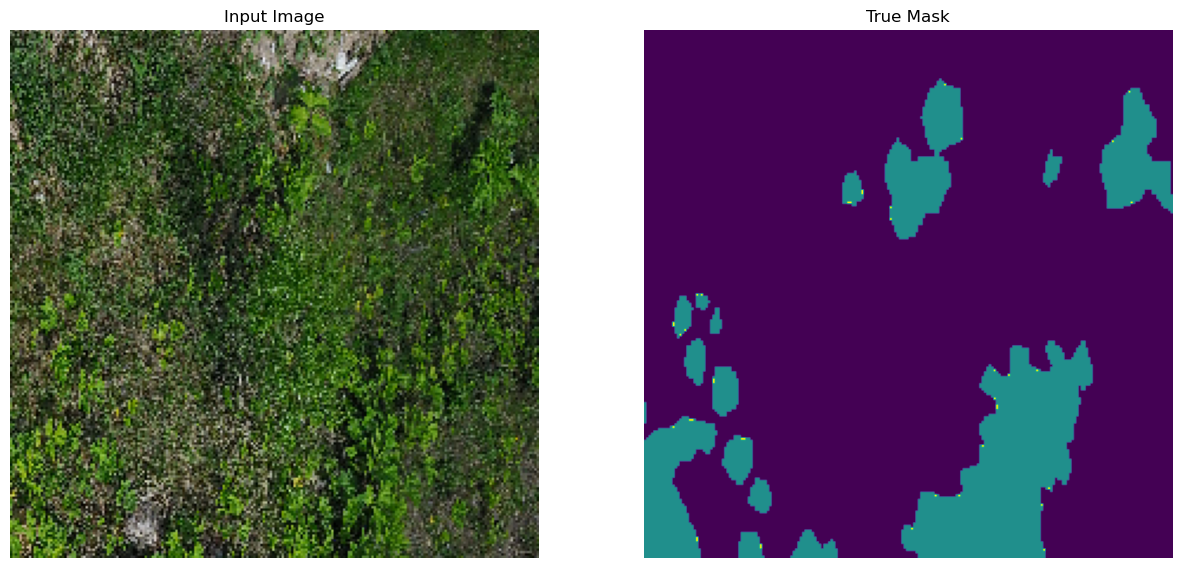

In [11]:
#### Kijken wat de oude masks waren

sample_image, sample_mask = images[9], masks[9]
display_list = [sample_image, sample_mask]  
display_images(display_list)